<a href="https://colab.research.google.com/github/vpste1/mlscrapbook/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [44]:
#hide
from fastbook import *
from fastai.vision.all import *

#Assembling the data

In [28]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [29]:
#hide
Path.BASE_PATH = path

In [30]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

Each subdirectory contains an image and a pose file:

In [31]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

We can get all the images easily with fastAI's `get_image_files`; we can then find the image's associated pose text files. E.g below we grab the first image, and input it into `img2pose` to find its associated pose file:

In [32]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('01/frame_00230_pose.txt')

We can see the first image below:

In [33]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

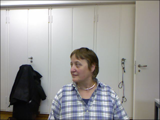

In [34]:
im.to_thumb(160)

The function below extracts the coordinates of the head center point (details aren't important):

In [35]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [36]:
get_ctr(img_files[0])

tensor([317.8583, 269.3681])

This coordinate for the image is the dependent variable, and so `get_ctr` can be used as the `get_y` for the `DataBlock`. We will be resizing the images for faster computation, and FastAI will automatically and correctly apply data augmentation to the coordinates (this isn't always the case for other libraries). In order to take advantage of this automatic data augmentation, we need to specify that the block is a `PointBlock` (as they are coordinates, a point in space).

When specifying the `splitter` for our `DataBlock` it's important to not use a random splitter. Since our dataset contains multiple images of the same person (in the same room, with the same clothes, etc.), we would most likely end up with the same person in both the training and validation sets. We would prefer to validate our model against new people, so we will be splitting on the basis of the people in the dataset. 

In [46]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

This is a good point to validate that the batch is looking correct:

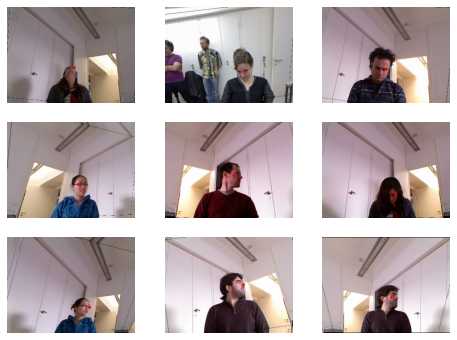

In [47]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

As always, it's always a good idea to validate the shape of the underlying tensors. Below you can see we have a batch size of 64, with each image being a 3-channel image of size 240x320; with the label being also a batch of 64, and a 2-point coordinate (X,Y).

In [48]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

((64, 3, 240, 320), (64, 1, 2))

In [49]:
yb[0]

TensorPoint([[-0.0363,  0.2001]], device='cuda:0')

#Training the model

Once again we will be making use of `cnn_learner` to create our `Learner`. Since all coordinates in fastai and PyTorch are rescaled between -1 and +1, we will be defining our `y_range` to be those limits (the limits of the image's boundaries):

In [55]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Since we didn't specify a loss function, fastai will choose the default:

In [51]:
dls.loss_func

FlattenedLoss of MSELoss()

`MSELoss` makes sense as we are aiming to be as close to the labelled target as possible (coordinates). We also haven't specified any metric, as the MSE is a valid metric in this scenario (no better, human-friendly alternative exists.

We can make use of the `lr_find()` which was explored in the MultiCategory book.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.033113110810518265)

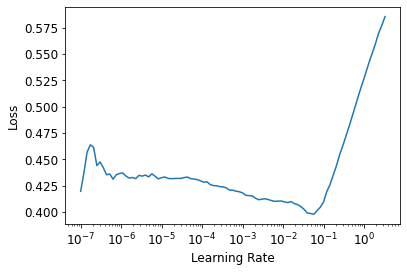

In [ ]:
learn.lr_find()

Picking a learning rate of around 1e-2 looks to be suitable

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049630,0.007602,00:42


epoch,train_loss,valid_loss,time
0,0.008714,0.004291,00:53
1,0.003213,0.000715,00:53
2,0.001482,0.000036,00:53


As always it's good to take a look at our results with `Learner.show_results` to compare the actual coordinates with our prediction:

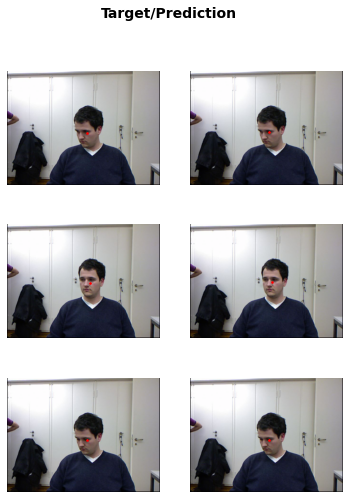

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))